In [2]:
import os, re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

BASE = "/home/hep/an1522/dark_tridents_wspace/outputs/inference"

MODELS = {
    "DM-CNN": {
        "bkg_dir": os.path.join(BASE, "run1_samples_mpid"),
        "sig_dir": os.path.join(BASE, "run1_signal_mpid"),
    },
    "ResNet18-GN": {
        "bkg_dir": os.path.join(BASE, "run1_samples_resnet18_gn"),
        "sig_dir": os.path.join(BASE, "run1_signal_resnet18_gn"),
    },
    "ResNet18-BN": {
        "bkg_dir": os.path.join(BASE, "run1_samples_resnet18_bn"),
        "sig_dir": os.path.join(BASE, "run1_signal_resnet18_bn"),
    },
    "ResNet34-GN": {
        "bkg_dir": os.path.join(BASE, "run1_samples_resnet34_gn"),
        "sig_dir": os.path.join(BASE, "run1_signal_resnet34_gn"),
    },
    "ResNet34-BN": {
        "bkg_dir": os.path.join(BASE, "run1_samples_resnet34_bn"),
        "sig_dir": os.path.join(BASE, "run1_signal_resnet34_bn"),
    },
}

SCORE_COL = "signal_score"


In [3]:
def load_scores_csv(csv_path, score_col="signal_score"):
    df = pd.read_csv(csv_path)
    s = pd.to_numeric(df[score_col], errors="coerce").to_numpy()
    s = s[np.isfinite(s)]
    s = s[s >= 0.0]   # drop placeholders like -999999.9
    return s

def load_background_scores(bkg_dir, score_col="signal_score"):
    bkg_dir = Path(bkg_dir)
    files = sorted(bkg_dir.glob("*_scores.csv"))
    if not files:
        raise FileNotFoundError(f"No *_scores.csv found in {bkg_dir}")
    all_scores = [load_scores_csv(f, score_col=score_col) for f in files]
    return np.concatenate(all_scores)

def compute_roc_auc(bkg_scores, sig_scores):
    y_true = np.r_[np.zeros(len(bkg_scores)), np.ones(len(sig_scores))].astype(int)
    y_score = np.r_[bkg_scores, sig_scores].astype(float)
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    return fpr, tpr, auc(fpr, tpr)

def parse_ratio_mass_from_name(fname):
    # expects something like run1_dt_ratio_0.6_ma_0.01_pi0_larcv_cropped_scores.csv
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_", fname)
    if not m:
        return None, None
    return float(m.group(1)), float(m.group(2))


In [4]:
bkg_scores = {}
for model_name, cfg in MODELS.items():
    bkg_scores[model_name] = load_background_scores(cfg["bkg_dir"], score_col=SCORE_COL)
    print(model_name, "bkg events:", len(bkg_scores[model_name]))


DM-CNN bkg events: 20955
ResNet18-GN bkg events: 20955
ResNet18-BN bkg events: 20955
ResNet34-GN bkg events: 20955
ResNet34-BN bkg events: 20955


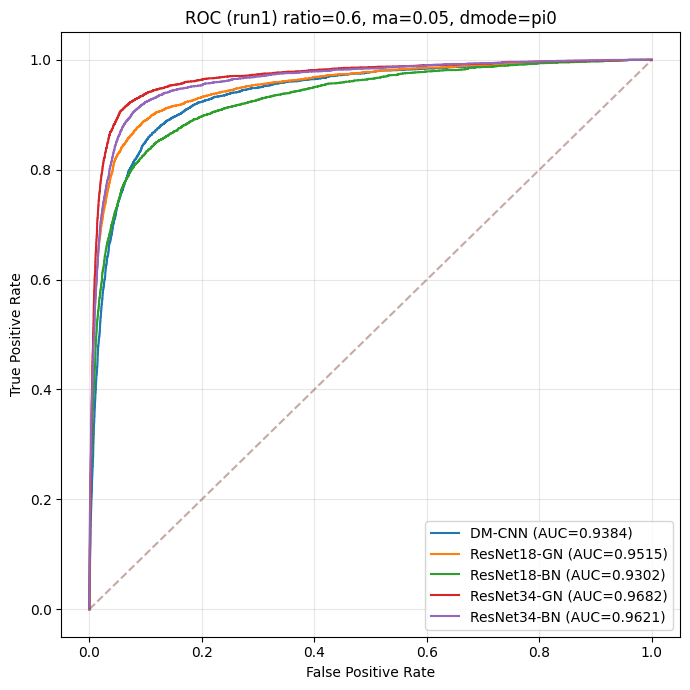

In [5]:
# parse ratio, mass, dmode from filename
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

TARGET_MASS = 0.05
RATIO = 0.6   # or 2.0
DMODE = "pi0" # "pi0" or "eta"

# collect signal files for DM-CNN folder
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# find the DM-CNN signal file matching ratio + mass + dmode
f_dmcnn = None
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if (abs(ratio - RATIO) < 1e-9) and (abs(mass - TARGET_MASS) < 1e-9) and (dmode == DMODE):
        f_dmcnn = f
        break

if f_dmcnn is None:
    raise FileNotFoundError(f"No signal file found for ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}")

plt.figure(figsize=(7, 7))

for model_name, cfg in MODELS.items():
    f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
    if not f_sig.exists():
        print(f"[skip] missing for {model_name}: {f_sig.name}")
        continue

    sig = load_scores_csv(f_sig, score_col=SCORE_COL)
    fpr, tpr, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC (run1) ratio={RATIO}, ma={TARGET_MASS}, dmode={DMODE}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
os.makedirs(out_dir, exist_ok=True)

plt.savefig(
    os.path.join(out_dir, f"ROC_ratio_{RATIO}_ma_{TARGET_MASS}_{DMODE}_run1.png"),
    dpi=200,
    bbox_inches="tight",
)

plt.show()

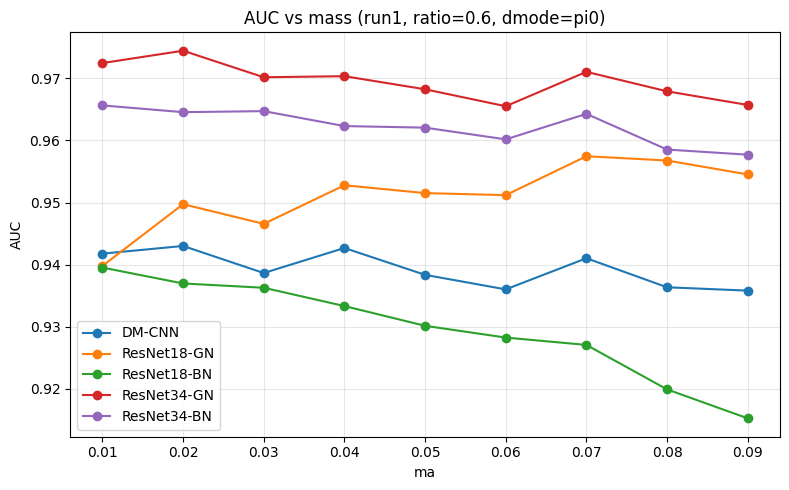

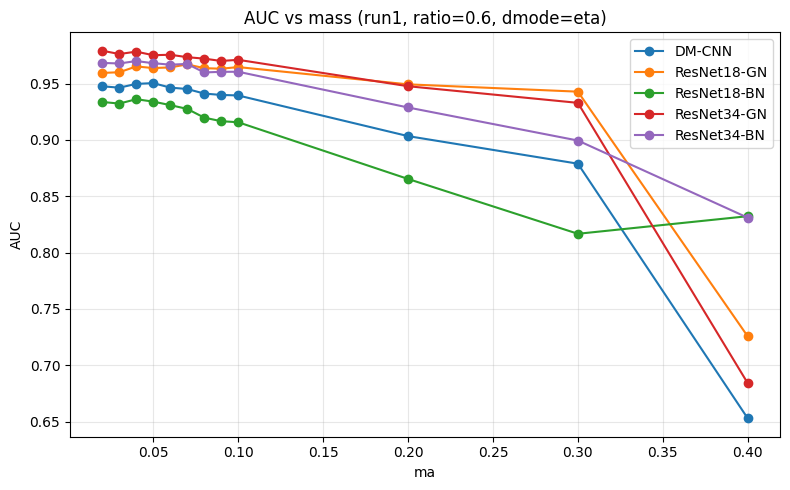

In [6]:
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0

# store AUC vs mass separately for pi0 and eta
auc_vs_mass = {
    "pi0": {m: [] for m in MODELS.keys()},
    "eta": {m: [] for m in MODELS.keys()},
}
masses = {"pi0": [], "eta": []}

sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# collect (mass, filename) per dmode for the chosen ratio
sig_by_mode = {"pi0": [], "eta": []}
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_by_mode[dmode].append((mass, f.name))

# sort by mass
for dmode in ["pi0", "eta"]:
    sig_by_mode[dmode] = sorted(sig_by_mode[dmode], key=lambda x: x[0])

# compute AUCs
for dmode in ["pi0", "eta"]:
    for mass, fname in sig_by_mode[dmode]:
        masses[dmode].append(mass)
        for model_name, cfg in MODELS.items():
            f_sig = Path(cfg["sig_dir"]) / fname
            if not f_sig.exists():
                auc_vs_mass[dmode][model_name].append(np.nan)
                continue
            sig = load_scores_csv(f_sig, score_col=SCORE_COL)
            _, _, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
            auc_vs_mass[dmode][model_name].append(auc_val)

# plot: pi0 and eta separately
for dmode in ["pi0", "eta"]:
    plt.figure(figsize=(8, 5))
    for model_name in MODELS.keys():
        plt.plot(masses[dmode], auc_vs_mass[dmode][model_name], marker="o", label=model_name)
    plt.xlabel("ma")
    plt.ylabel("AUC")
    plt.title(f"AUC vs mass (run1, ratio={RATIO}, dmode={dmode})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
    os.makedirs(out_dir, exist_ok=True)
    
    plt.savefig(
        os.path.join(out_dir, f"AUC_ratio_{RATIO}_{dmode}_overall_run1.png"),
        dpi=200,
        bbox_inches="tight",
    )
    
    plt.show()



In [7]:
# Parse ratio, mass, and dmode (pi0/eta) from filename
def parse_ratio_mass_dmode(fname):
    # example: run1_dt_ratio_0.6_ma_0.01_pi0_larcv_cropped_scores.csv
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

RATIO = 0.6  # or 2.0

# collect signal files for DM-CNN folder (use that as the "list of mass points")
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

# filter to ratio and keep (mass, dmode, file)
sig_files_ratio = []
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_files_ratio.append((mass, dmode, f))

sig_files_ratio = sorted(sig_files_ratio, key=lambda x: (x[0], x[1]))
print(f"Found {len(sig_files_ratio)} signal files for ratio={RATIO}")

# # One figure per mass+dmode, comparing models
# for mass, dmode, f_dmcnn in sig_files_ratio:
#     plt.figure(figsize=(7, 7))

#     for model_name, cfg in MODELS.items():
#         # pick the matching signal file name in that model's signal dir
#         f_sig = Path(cfg["sig_dir"]) / f_dmcnn.name
#         if not f_sig.exists():
#             print(f"[skip] missing for {model_name}: {f_sig.name}")
#             continue

#         sig = load_scores_csv(f_sig, score_col=SCORE_COL)
#         fpr, tpr, auc_val = compute_roc_auc(bkg_scores[model_name], sig)
#         plt.plot(fpr, tpr, label=f"{model_name} (AUC={auc_val:.4f})")

#     plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.5)
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.title(f"ROC (run1) ratio={RATIO}, ma={mass}, dmode={dmode}")
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


Found 21 signal files for ratio=0.6


In [8]:
# --- New Cell: AUC uncertainty helpers (Bootstrap + DeLong) ---

import math
import numpy as np
from sklearn.metrics import roc_auc_score

# Normal quantile helper (uses scipy if available; falls back to common z's)
try:
    from scipy.stats import norm
    def _z_for_ci(alpha: float) -> float:
        return float(norm.ppf(0.5 + alpha/2.0))
except Exception:
    def _z_for_ci(alpha: float) -> float:
        # fallback for common confidence levels
        if abs(alpha - 0.90) < 1e-12: return 1.6448536269514722
        if abs(alpha - 0.95) < 1e-12: return 1.959963984540054
        if abs(alpha - 0.99) < 1e-12: return 2.5758293035489004
        # reasonable default
        return 1.959963984540054


def make_labels_scores(bkg_scores_arr, sig_scores_arr, subsample_per_class=None, seed=12345):
    """
    Builds y_true/y_score from background + signal score arrays.
    Optionally subsample each class to subsample_per_class (for speed).
    """
    bkg = np.asarray(bkg_scores_arr, dtype=float)
    sig = np.asarray(sig_scores_arr, dtype=float)

    if subsample_per_class is not None:
        rng = np.random.default_rng(seed)
        nb = min(len(bkg), int(subsample_per_class))
        ns = min(len(sig), int(subsample_per_class))
        bkg = bkg[rng.choice(len(bkg), size=nb, replace=False)]
        sig = sig[rng.choice(len(sig), size=ns, replace=False)]

    y_true = np.r_[np.zeros(len(bkg), dtype=int), np.ones(len(sig), dtype=int)]
    y_score = np.r_[bkg, sig].astype(float)
    return y_true, y_score


def bootstrap_auc_ci(y_true, y_score, n_boot=2000, alpha=0.95, seed=12345, stratified=True):
    """
    Stratified bootstrap (recommended): resample positives/negatives separately.
    Returns: (auc_hat, boot_se, (ci_low, ci_high), auc_samples)
    """
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)

    pos_idx = np.flatnonzero(y_true == 1)
    neg_idx = np.flatnonzero(y_true == 0)
    m, n = len(pos_idx), len(neg_idx)
    if m == 0 or n == 0:
        raise ValueError("Need both positive and negative samples for AUC.")

    auc_hat = float(roc_auc_score(y_true, y_score))
    rng = np.random.default_rng(seed)

    aucs = np.empty(int(n_boot), dtype=float)
    for b in range(int(n_boot)):
        if stratified:
            samp_pos = rng.choice(pos_idx, size=m, replace=True)
            samp_neg = rng.choice(neg_idx, size=n, replace=True)
            idx = np.r_[samp_neg, samp_pos]
            aucs[b] = roc_auc_score(y_true[idx], y_score[idx])
        else:
            idx = rng.choice(len(y_true), size=len(y_true), replace=True)
            # reject pathological resamples with single class
            if len(np.unique(y_true[idx])) < 2:
                aucs[b] = np.nan
            else:
                aucs[b] = roc_auc_score(y_true[idx], y_score[idx])

    aucs = aucs[np.isfinite(aucs)]
    ci_low = float(np.quantile(aucs, (1 - alpha) / 2))
    ci_high = float(np.quantile(aucs, 1 - (1 - alpha) / 2))
    se = float(np.std(aucs, ddof=1)) if len(aucs) > 1 else float("nan")
    return auc_hat, se, (ci_low, ci_high), aucs


# ---------------- DeLong (fast) ----------------

def _compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)

    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        mid = 0.5 * (i + j - 1) + 1  # 1-based midrank
        T[i:j] = mid
        i = j

    T2 = np.empty(N, dtype=float)
    T2[J] = T
    return T2


def _fast_delong(predictions_sorted_transposed, label_1_count):
    """
    predictions_sorted_transposed: shape (k, n_examples) with positives first
    label_1_count: number of positives (m)
    Returns (aucs, delong_cov)
    """
    m = int(label_1_count)
    n = predictions_sorted_transposed.shape[1] - m
    k = predictions_sorted_transposed.shape[0]

    pos = predictions_sorted_transposed[:, :m]
    neg = predictions_sorted_transposed[:, m:]

    tx = np.empty((k, m), dtype=float)
    ty = np.empty((k, n), dtype=float)
    tz = np.empty((k, m + n), dtype=float)

    for r in range(k):
        tz[r] = _compute_midrank(predictions_sorted_transposed[r])
        tx[r] = _compute_midrank(pos[r])
        ty[r] = _compute_midrank(neg[r])

    aucs = (tz[:, :m].sum(axis=1) - m * (m + 1) / 2.0) / (m * n)

    v01 = (tz[:, :m] - tx) / n
    v10 = 1.0 - (tz[:, m:] - ty) / m

    sx = np.cov(v01, bias=False)
    sy = np.cov(v10, bias=False)
    if k == 1:
        sx = np.array([[sx]])
        sy = np.array([[sy]])

    delong_cov = sx / m + sy / n
    return aucs, delong_cov


def delong_auc_ci(y_true, y_score, alpha=0.95):
    """
    DeLong variance + normal-approx CI.
    Returns: (auc, auc_se, (ci_low, ci_high))
    """
    y_true = np.asarray(y_true, dtype=int)
    y_score = np.asarray(y_score, dtype=float)

    # sort so positives are first
    order = np.argsort(-y_true)
    y_true_sorted = y_true[order]
    y_score_sorted = y_score[order]

    m = int(y_true_sorted.sum())
    if m == 0 or m == len(y_true_sorted):
        raise ValueError("Need both positive and negative samples for AUC.")

    preds = y_score_sorted[np.newaxis, :]
    aucs, cov = _fast_delong(preds, m)

    auc = float(aucs[0])
    var = float(cov[0, 0])
    se = math.sqrt(max(var, 0.0))

    z = _z_for_ci(alpha)
    ci_low = max(0.0, auc - z * se)
    ci_high = min(1.0, auc + z * se)
    return auc, se, (ci_low, ci_high)


In [ ]:
# --- New Cell: compute AUC + uncertainty for each mass point and model ---

# SETTINGS
ALPHA = 0.95                 # 95% CI
N_BOOT = 2000                # increase to ~2000+ for smoother bootstrap CIs
SEED = 12345
SUBSAMPLE_PER_CLASS = None   # e.g. 50000 if this gets slow; None uses all events

# Parse ratio, mass, dmode from filename (if not already defined above)
def parse_ratio_mass_dmode(fname):
    m = re.search(r"dt_ratio_([0-9.]+)_ma_([0-9.]+)_(pi0|eta)_", fname)
    if not m:
        return None, None, None
    return float(m.group(1)), float(m.group(2)), m.group(3)

# Gather signal filenames from DM-CNN as the "canonical list" of mass points
sig_files = sorted(Path(MODELS["DM-CNN"]["sig_dir"]).glob("*_scores.csv"))

sig_by_mode = {"pi0": [], "eta": []}
for f in sig_files:
    ratio, mass, dmode = parse_ratio_mass_dmode(f.name)
    if ratio is None:
        continue
    if abs(ratio - RATIO) < 1e-9:
        sig_by_mode[dmode].append((mass, f.name))

for dmode in ["pi0", "eta"]:
    sig_by_mode[dmode] = sorted(sig_by_mode[dmode], key=lambda x: x[0])

# Compute stats: one row per (dmode, mass, model)
auc_stats = {dmode: {model: [] for model in MODELS.keys()} for dmode in ["pi0", "eta"]}

for dmode in ["pi0", "eta"]:
    for mass, fname in sig_by_mode[dmode]:
        for model_name, cfg in MODELS.items():
            f_sig = Path(cfg["sig_dir"]) / fname
            if not f_sig.exists():
                auc_stats[dmode][model_name].append({
                    "mass": mass, "auc": np.nan,
                    "delong_se": np.nan, "delong_ci_low": np.nan, "delong_ci_high": np.nan,
                    "boot_se": np.nan, "boot_ci_low": np.nan, "boot_ci_high": np.nan,
                    "n_sig": 0, "n_bkg": 0,
                })
                continue

            sig = load_scores_csv(f_sig, score_col=SCORE_COL)
            bkg = bkg_scores[model_name]

            y_true, y_score = make_labels_scores(
                bkg, sig,
                subsample_per_class=SUBSAMPLE_PER_CLASS,
                seed=SEED
            )

            auc_hat = float(roc_auc_score(y_true, y_score))

            # DeLong
            auc_d, se_d, ci_d = delong_auc_ci(y_true, y_score, alpha=ALPHA)

            # Bootstrap (stratified)
            auc_b, se_b, ci_b, _ = bootstrap_auc_ci(
                y_true, y_score,
                n_boot=N_BOOT,
                alpha=ALPHA,
                seed=SEED,
                stratified=True
            )

            auc_stats[dmode][model_name].append({
                "mass": mass,
                "auc": auc_hat,
                "delong_se": se_d,
                "delong_ci_low": ci_d[0],
                "delong_ci_high": ci_d[1],
                "boot_se": se_b,
                "boot_ci_low": ci_b[0],
                "boot_ci_high": ci_b[1],
                "n_sig": int((y_true == 1).sum()),
                "n_bkg": int((y_true == 0).sum()),
            })

print("Done. Example row:")
print("pi0 /", list(MODELS.keys())[0], "=>", auc_stats["pi0"][list(MODELS.keys())[0]][0])


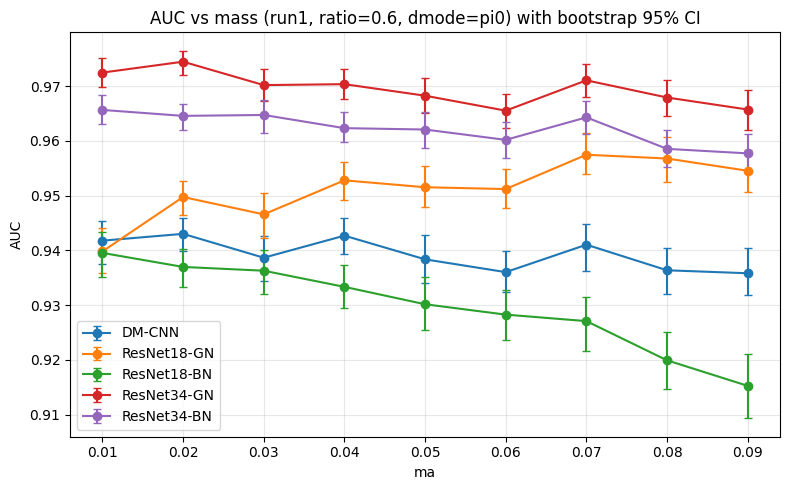

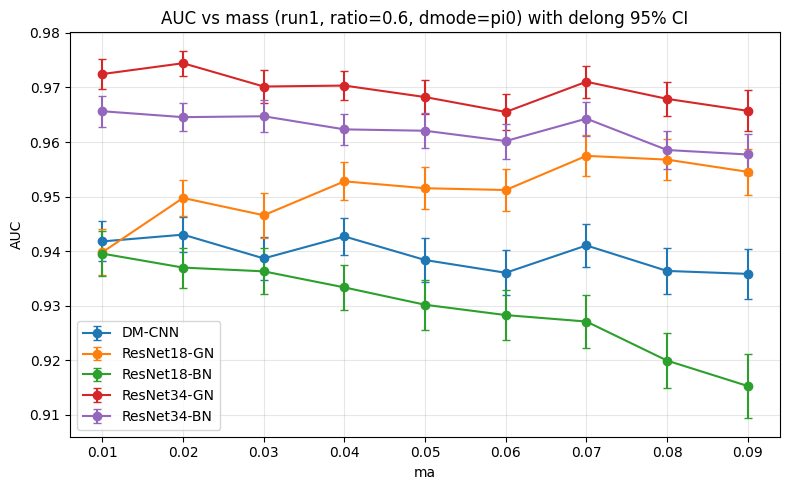

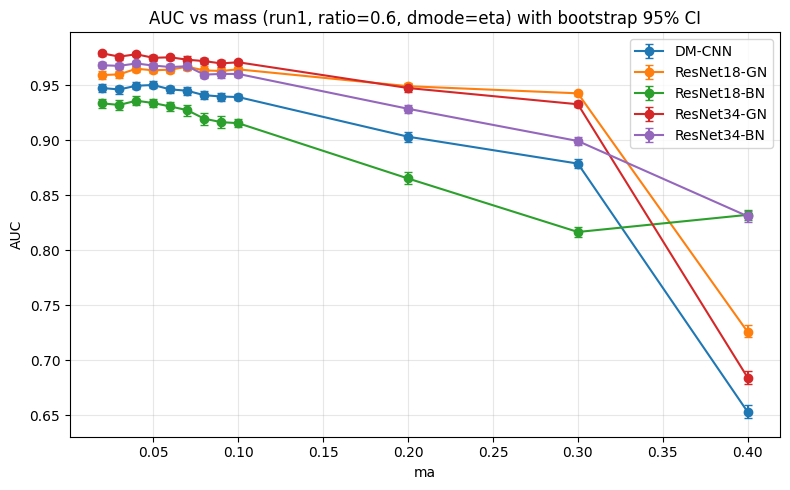

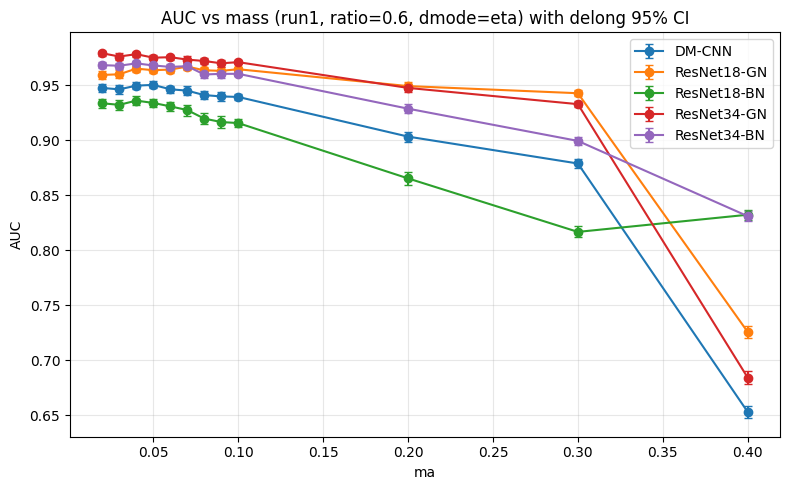

In [15]:
# --- New Cell: plot AUC vs mass with error bars (bootstrap or DeLong) ---

# Choose which CI you want to plot as error bars:
PLOT_METHODS = ["bootstrap", "delong"]       # "delong" or "bootstrap"

out_dir = "/home/hep/an1522/dark_tridents_wspace/outputs/roc_auc"
os.makedirs(out_dir, exist_ok=True)

for dmode in ["pi0", "eta"]:
    for PLOT_METHOD in PLOT_METHODS:
        plt.figure(figsize=(8, 5))
    
        for model_name in MODELS.keys():
            rows = auc_stats[dmode][model_name]
            masses_plot = [r["mass"] for r in rows]
            aucs_plot = [r["auc"] for r in rows]
    
            if PLOT_METHOD.lower() == "bootstrap":
                lo = [r["boot_ci_low"] for r in rows]
                hi = [r["boot_ci_high"] for r in rows]
            else:
                lo = [r["delong_ci_low"] for r in rows]
                hi = [r["delong_ci_high"] for r in rows]
    
            # asymmetric error bars
            yerr_low = [a - l if np.isfinite(a) and np.isfinite(l) else np.nan for a, l in zip(aucs_plot, lo)]
            yerr_high = [h - a if np.isfinite(a) and np.isfinite(h) else np.nan for a, h in zip(aucs_plot, hi)]
    
            plt.errorbar(
                masses_plot, aucs_plot,
                yerr=[yerr_low, yerr_high],
                marker="o",
                capsize=3,
                label=model_name
            )
    
        plt.xlabel("ma")
        plt.ylabel("AUC")
        plt.title(f"AUC vs mass (run1, ratio={RATIO}, dmode={dmode}) with {PLOT_METHOD} {int(ALPHA*100)}% CI")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
    
        fname = f"AUC_ratio_{RATIO}_{dmode}_overall_run1_with_{PLOT_METHOD}_CI.png"
        plt.savefig(os.path.join(out_dir, fname), dpi=200, bbox_inches="tight")
        plt.show()
